In [1]:
import wfdb
import pickle
from scipy import interpolate

import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
import torch.nn as nn
from torchvision import transforms, datasets
from torchvision.models import resnet18, resnet34, resnet50
from tqdm import tqdm
from collections import Counter
from info_nce import InfoNCE
import matplotlib.colors as mcolors

import os
import pandas as pd
import einops
from scipy.stats import mode
import torch.optim as optim
from sklearn.metrics import f1_score
import sys
from torch.utils import data

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import src.config, src.utils, src.models, src.data
import torchvision

import torch
from torch.utils.data import DataLoader, Dataset, Subset
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import random

from sklearn.datasets import load_iris
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import calinski_harabasz_score
import matplotlib.pyplot as plt
import numpy

from torch.nn import GRU, Linear, CrossEntropyLoss
from torch.optim import Adam
from torch.utils.data import random_split
from sklearn.metrics import precision_score, recall_score

print("torchvision version:", torchvision.__version__)

torchvision version: 0.17.0


In [2]:
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.use_deterministic_algorithms(True)

In [3]:
# Local imports
DATA_DIR = "./data"

In [4]:
flipped_afib_dict = {0: "W", 1: "N1", 2: "N2", 3: "N3", 4: "REM"}

In [5]:
class SLEEPDataset(Dataset):
    
    def __init__(self, data_path, seq_length=500):
        """
        Args:
            x_data (Tensor): The input features, e.g., from STFT.
            y_data (Tensor): The corresponding labels, windowed and processed.
            seq_length (int): The length of each sequence.
        """
        
        # Load each of the pickle files
        data = torch.load(f'./{data_path}/train.pt')
        self.x_data = data['samples'].squeeze()
        self.y_data = data['labels']
    
        
        self.seq_length = seq_length
        
    def __len__(self):
        # Return the number of full sequences in the dataset
        return len(self.x_data) // self.seq_length

    def __getitem__(self, idx):
        """
        Returns a tuple (input, label) for the given index.
        The input is reshaped to (seq_length, features).
        """
        start_idx = idx * self.seq_length
        end_idx = start_idx + self.seq_length

        # Extract the sequence of data and corresponding labels
        x_seq = self.x_data[start_idx:end_idx]
        y_seq = self.y_data[start_idx:end_idx]

        return x_seq, y_seq

In [6]:
data = torch.load(f'data/sleepeeg/train.pt')
tensor_data = data['samples']
y_data = data['labels']

In [7]:
tensor_data.shape

torch.Size([371055, 1, 178])

In [8]:
y_data.shape

torch.Size([371055])

In [9]:
# Get unique labels and their counts
unique_labels, counts = np.unique(y_data, return_counts=True)

# Print the results
for label, count in zip(unique_labels, counts):
    print(f"Label {label}: {count} occurrences")

Label 0: 51345 occurrences
Label 1: 24345 occurrences
Label 2: 158550 occurrences
Label 3: 58650 occurrences
Label 4: 78165 occurrences


In [10]:
def count_consecutive_labels(labels):
    if len(labels) == 0:
        return []

    result = []
    current_label = labels[0]
    count = 1

    for i in range(1, len(labels)):
        if labels[i] == current_label:
            count += 1
        else:
            result.append((current_label, count))
            current_label = labels[i]
            count = 1

    # Append the last label count
    result.append((current_label, count))
    return result

labels = y_data
consecutive_counts = count_consecutive_labels(labels)

for label, count in consecutive_counts:
    if label != 3:
        print(f"Label {label}: {count} times")

Label 0: 60 times
Label 1: 45 times
Label 2: 105 times
Label 1: 15 times
Label 2: 60 times
Label 1: 15 times
Label 2: 15 times
Label 1: 15 times
Label 2: 120 times
Label 0: 15 times
Label 1: 30 times
Label 0: 30 times
Label 1: 15 times
Label 0: 15 times
Label 1: 15 times
Label 0: 30 times
Label 1: 15 times
Label 2: 150 times
Label 0: 15 times
Label 1: 15 times
Label 2: 255 times
Label 2: 15 times
Label 2: 555 times
Label 4: 45 times
Label 2: 75 times
Label 4: 60 times
Label 0: 315 times
Label 1: 15 times
Label 2: 705 times
Label 2: 30 times
Label 2: 15 times
Label 0: 45 times
Label 2: 105 times
Label 4: 1065 times
Label 2: 45 times
Label 4: 105 times
Label 0: 15 times
Label 4: 15 times
Label 2: 285 times
Label 0: 120 times
Label 2: 240 times
Label 1: 30 times
Label 2: 15 times
Label 0: 30 times
Label 2: 210 times
Label 0: 30 times
Label 1: 30 times
Label 2: 915 times
Label 1: 15 times
Label 2: 165 times
Label 0: 150 times
Label 1: 30 times
Label 2: 120 times
Label 4: 1020 times
Label 2

In [11]:
class SequentialRandomSampler(torch.utils.data.Sampler):
    def __init__(self, data_source, batch_size):
        self.data_source = data_source
        self.batch_size = batch_size


    def __iter__(self):
        

        indices = list(range(len(self.data_source)))
        
        remaining = len(indices) % self.batch_size
        if remaining > 0:
            indices = indices[:-remaining]
        final_indices = np.reshape(indices, (-1, self.batch_size))

        # Shuffle the batches
        np.random.shuffle(final_indices)

        # Flatten the list of batches to get the final order of indices
        final_indices = [idx for batch in final_indices for idx in batch]
        
        return iter(final_indices)

    def __len__(self):
        return len(self.data_source)

In [196]:
dataset = SLEEPDataset("data/sleepeeg", seq_length=300)
valid_split = 0.2
            
valid_amount = int(np.floor(len(dataset)*valid_split))
train_amount = len(dataset) - valid_amount


train_indices = list(range(train_amount))
valid_indices = list(range(train_amount, train_amount + valid_amount))

# Create subsets
train_ds = Subset(dataset, train_indices)
valid_ds = Subset(dataset, valid_indices)

# train_ds, valid_ds = random_split(dataset, [train_amount, valid_amount])
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

batch_size= 32
train_loader = torch.utils.data.DataLoader(
    dataset=train_ds,
    batch_size=batch_size,
#     sampler=SequentialRandomSampler(train_ds, batch_size),
    shuffle = True,
    num_workers=0,
    drop_last = True,
    worker_init_fn=seed_worker
)

valid_loader = torch.utils.data.DataLoader(
    dataset=valid_ds,
    batch_size=247,
#             sampler=SequentialRandomSampler(valid_ds, args['batch_size']),
    shuffle = False,
    num_workers=0,
    drop_last = True,
    worker_init_fn=seed_worker
)

In [197]:
valid_amount

247

In [198]:
len(train_ds)

989

In [199]:
len(valid_ds)

247

In [200]:
len(valid_loader)

1

In [16]:
# Create a DataLoader to iterate over the dataset
data_loader = DataLoader(train_ds, batch_size=512, shuffle=False)

# Initialize a list to store all labels
all_labels = []

# Iterate over the DataLoader to collect all labels
for _, labels in data_loader:
    all_labels.extend(labels.numpy())  # Convert the labels to numpy and extend the list

# Convert the list of labels to a numpy array
tall_labels = np.array(all_labels)

# Get unique labels and their counts
unique_labels, counts = np.unique(tall_labels, return_counts=True)

# Print the results
for label, count in zip(unique_labels, counts):
    print(f"Label {label}: {count} occurrences")

Label 0: 46545 occurrences
Label 1: 20400 occurrences
Label 2: 122550 occurrences
Label 3: 47445 occurrences
Label 4: 59760 occurrences


In [17]:
# Create a DataLoader to iterate over the dataset
data_loader = DataLoader(valid_ds, batch_size=512, shuffle=False)

# Initialize a list to store all labels
all_labels = []

# Iterate over the DataLoader to collect all labels
for _, labels in data_loader:
    all_labels.extend(labels.numpy())  # Convert the labels to numpy and extend the list

# Convert the list of labels to a numpy array
vall_labels = np.array(all_labels)

# Get unique labels and their counts
unique_labels, counts = np.unique(vall_labels, return_counts=True)

# Print the results
for label, count in zip(unique_labels, counts):
    print(f"Label {label}: {count} occurrences")

Label 0: 4575 occurrences
Label 1: 3915 occurrences
Label 2: 36000 occurrences
Label 3: 11205 occurrences
Label 4: 18405 occurrences


In [18]:
all_labels[1].shape

(300,)

In [19]:
def count_consecutive_labels(labels):
    if len(labels) == 0:
        return []

    result = []
    current_label = labels[0]
    count = 1

    for i in range(1, len(labels)):
        if labels[i] == current_label:
            count += 1
        else:
            result.append((current_label, count))
            current_label = labels[i]
            count = 1

    # Append the last label count
    result.append((current_label, count))
    return result

labels = vall_labels.reshape(-1)
consecutive_counts = count_consecutive_labels(labels)

for label, count in consecutive_counts:
    print(f"Label {label}: {count} times")

Label 4: 1005 times
Label 2: 570 times
Label 0: 60 times
Label 1: 45 times
Label 2: 150 times
Label 0: 90 times
Label 1: 150 times
Label 2: 45 times
Label 0: 90 times
Label 1: 120 times
Label 2: 75 times
Label 0: 45 times
Label 1: 60 times
Label 2: 150 times
Label 0: 120 times
Label 1: 15 times
Label 0: 15 times
Label 1: 60 times
Label 2: 30 times
Label 1: 45 times
Label 2: 165 times
Label 0: 120 times
Label 1: 45 times
Label 2: 600 times
Label 3: 255 times
Label 2: 120 times
Label 3: 15 times
Label 2: 30 times
Label 3: 45 times
Label 2: 15 times
Label 4: 360 times
Label 2: 660 times
Label 3: 15 times
Label 2: 30 times
Label 3: 150 times
Label 2: 15 times
Label 3: 255 times
Label 2: 30 times
Label 3: 15 times
Label 2: 15 times
Label 3: 810 times
Label 2: 15 times
Label 3: 30 times
Label 2: 30 times
Label 4: 720 times
Label 2: 915 times
Label 1: 15 times
Label 0: 285 times
Label 1: 60 times
Label 0: 15 times
Label 1: 45 times
Label 2: 750 times
Label 3: 15 times
Label 2: 30 times
Label 

In [20]:
class FeatureProjector(nn.Module):
    def __init__(self, input_size=156, output_size=32):
        super(FeatureProjector, self).__init__()
        
        # 1D Convolutional Layers
        self.conv1 = nn.Conv1d(in_channels=input_size, out_channels=128, kernel_size=1)
        self.conv2 = nn.Conv1d(in_channels=128, out_channels=64, kernel_size=1)
        self.conv3 = nn.Conv1d(in_channels=64, out_channels=output_size, kernel_size=1)
        
        # Batch Normalization
        self.bn1 = nn.BatchNorm1d(128)
        self.bn2 = nn.BatchNorm1d(64)
        self.bn3 = nn.BatchNorm1d(output_size)
        
    def forward(self, x):
        # Input x shape: (batch_size, sequence_length, input_size)
        
        # Permute to match Conv1D input: (batch_size, input_size, sequence_length)
        x = x.float()
        x = x.permute(0, 2, 1)
        
        # First convolutional layer
        x = self.conv1(x)  # Shape: (batch_size, 128, sequence_length)
        x = self.bn1(x)
        x = F.relu(x)
        
        # Second convolutional layer
        x = self.conv2(x)  # Shape: (batch_size, 64, sequence_length)
        x = self.bn2(x)
        x = F.relu(x)
        
        # Third convolutional layer
        x = self.conv3(x)  # Shape: (batch_size, output_size, sequence_length)
        x = self.bn3(x)
        x = F.relu(x)
        
        # Permute back to original order: (batch_size, sequence_length, output_size)
        x = x.permute(0, 2, 1)
        
        return x

In [21]:
class FeatureProjector2(nn.Module):
    def __init__(self, input_size=156, output_size=32):
        super(FeatureProjector2, self).__init__()
        
        # 1D Convolutional Layers with ReLU activations and Batch Normalization
        self.conv1 = nn.Conv1d(in_channels=input_size, out_channels=128, kernel_size=3)
        self.bn1 = nn.BatchNorm1d(128)
        self.relu1 = nn.ReLU()
        
        self.conv2 = nn.Conv1d(in_channels=128, out_channels=64, kernel_size=3)
        self.bn2 = nn.BatchNorm1d(64)
        self.relu2 = nn.ReLU()
        
        self.conv3 = nn.Conv1d(in_channels=64, out_channels=output_size, kernel_size=3)
        self.bn3 = nn.BatchNorm1d(output_size)
        self.relu3 = nn.ReLU()
        
    def forward(self, x):
        # Input x shape: (batch_size, sequence_length, input_size)
        
        # Permute to match Conv1D input: (batch_size, input_size, sequence_length)
        x = x.float()
        x = x.permute(0, 2, 1)
        
        # First convolutional layer
        x = self.conv1(x)  # Shape: (batch_size, 128, sequence_length - 2)
        x = self.bn1(x)
        x = self.relu1(x)
        
        # Second convolutional layer
        x = self.conv2(x)  # Shape: (batch_size, 64, sequence_length - 4)
        x = self.bn2(x)
        x = self.relu2(x)
        
        # Third convolutional layer
        x = self.conv3(x)  # Shape: (batch_size, output_size, sequence_length - 6)
        x = self.bn3(x)
        x = self.relu3(x)
        
        # Permute back to original order: (batch_size, sequence_length - 6, output_size)
        x = x.permute(0, 2, 1)
        
        return x


In [22]:
class ECGEncoder(nn.Module):
    def __init__(self, input_size=102, output_size=64):
        super(ECGEncoder, self).__init__()
        
        self.conv1 = nn.Conv1d(input_size, 32, kernel_size=7, stride=2, padding=3)  # Downsampling by 2
        self.conv2 = nn.Conv1d(32, 64, kernel_size=7, stride=2, padding=3)             # Downsampling by 2
        self.conv3 = nn.Conv1d(64, 128, kernel_size=7, stride=2, padding=3)            # Downsampling by 2
        self.conv4 = nn.Conv1d(128, 256, kernel_size=7, stride=2, padding=3)           # Downsampling by 2
        self.conv5 = nn.Conv1d(256, 512, kernel_size=7, stride=2, padding=3)           # Downsampling by 2
        self.conv6 = nn.Conv1d(512, 1024, kernel_size=7, stride=2, padding=3)          # Downsampling by 2
        
        # Fully connected layer to map to the 64-dimensional output
        self.fc = nn.Linear(1024, output_size)
        
    def forward(self, x):
        x = x.float()
        x = x.permute(0, 2, 1)
        
        # Apply each convolutional layer with ReLU activation
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))
        x = F.relu(self.conv6(x))
        
        # Global average pooling (to get a single vector for each channel)
#         x = F.adaptive_avg_pool1d(x, 1).squeeze(-1)
        
        # Final fully connected layer to produce 64-dimensional vector
#         x = self.fc(x)
#         x = x.permute(0, 2, 1)
        
        return x

In [23]:
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def initialize_model_supervised(seed):
    set_seed(seed)
    model = FeatureProjector(input_size=178, output_size=5)
    return model

In [24]:
# Instantiate the model
seed = 42
attn_model = initialize_model_supervised(seed)

In [25]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(attn_model.parameters(), lr=0.001)  # Example optimizer

# Move model to device
device = torch.device("cpu" if torch.backends.mps.is_available() and torch.backends.mps.is_built() else "cpu")
attn_model.to(device)

# Training and validation loop
num_epochs = 15
for epoch in range(num_epochs):
    # Training phase
    attn_model.train()  # Set the model to training mode
    train_running_loss = 0.0
    train_correct_predictions = 0
    train_total_samples = 0
    
    all_preds = []
    all_labels = []
    
    for time_series, labels in tqdm(train_loader):
        time_series = time_series.to(device)
        labels = labels.to(device)
        
        # Forward pass
        features = attn_model(time_series)

        # Flatten y_hat to have dimensions [batch_size * sequence_length, num_classes]
        y_hat_flat = features.reshape(-1, features.size(-1))

        # Reshape y to have dimensions [batch_size * sequence_length]
        labels_flat = labels.view(-1)
        
        # Compute training loss
        train_loss = criterion(y_hat_flat, labels_flat)

        # Backward pass and optimization
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        # Update training statistics
        train_running_loss += train_loss.item() * time_series.size(0)
        
        _, predicted = torch.max(y_hat_flat, 1)
        train_correct_predictions += (predicted == labels_flat).sum().item()
        
        #Store the labels for future computation of F1-score
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels_flat.cpu().numpy())
        
        train_total_samples += labels_flat.size(0)
    
    # Calculate average training loss and accuracy for the epoch
    train_epoch_loss = train_running_loss / len(train_loader.dataset)
    train_epoch_accuracy = 100*train_correct_predictions / train_total_samples
    
    f1 = f1_score(all_labels, all_preds,average='weighted')
    
    print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_epoch_loss:.4f},\
          Train Accuracy: {train_epoch_accuracy:.2f}%, F1-score: {f1:.4f}")

    # Validation phase
    attn_model.eval()  # Set the model to evaluation mode
    val_running_loss = 0.0
    val_correct_predictions = 0
    val_total_samples = 0
    
    with torch.no_grad():
        val_preds = []
        val_labels = []
        for time_series, labels in tqdm(valid_loader):
            time_series = time_series.to(device)
            labels = labels.to(device)

            # Forward pass
            features = attn_model(time_series)

            # Flatten y_hat to have dimensions [batch_size * sequence_length, num_classes]
            y_hat_flat = features.reshape(-1, features.size(-1))

            # Reshape y to have dimensions [batch_size * sequence_length]
            labels_flat = labels.view(-1)

            # Compute validation loss
            val_loss = criterion(y_hat_flat, labels_flat)

            # Update validation statistics
            val_running_loss += val_loss.item() * time_series.size(0)
            
            _, predicted = torch.max(y_hat_flat, 1)
            val_correct_predictions += (predicted == labels_flat).sum().item()
            val_total_samples += labels_flat.size(0)
            
            val_preds.extend(predicted.cpu().numpy())
            val_labels.extend(labels_flat.cpu().numpy())
    
    # Calculate average validation loss and accuracy for the epoch
    val_epoch_loss = val_running_loss / len(valid_loader.dataset)
    val_epoch_accuracy = 100*val_correct_predictions / val_total_samples
    
    f1 = f1_score(val_labels, val_preds, average='weighted')
    print(f"Epoch {epoch + 1}/{num_epochs}, Val Loss: {val_epoch_loss:.4f},\
          Val Accuracy: {val_epoch_accuracy:.2f}%, F1-score: {f1:.2f}")

print("Training and validation complete.")

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  7.45it/s]


Epoch 1/15, Train Loss: 1.4860,          Train Accuracy: 34.61%, F1-score: 0.3448


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  8.51it/s]


Epoch 1/15, Val Loss: 1.3337,          Val Accuracy: 42.25%, F1-score: 0.40


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  7.33it/s]


Epoch 2/15, Train Loss: 1.3829,          Train Accuracy: 43.99%, F1-score: 0.4219


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  8.45it/s]


Epoch 2/15, Val Loss: 1.2769,          Val Accuracy: 47.69%, F1-score: 0.46


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  7.42it/s]


Epoch 3/15, Train Loss: 1.3180,          Train Accuracy: 48.96%, F1-score: 0.4741


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  8.67it/s]


Epoch 3/15, Val Loss: 1.2339,          Val Accuracy: 49.78%, F1-score: 0.48


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  6.82it/s]


Epoch 4/15, Train Loss: 1.2547,          Train Accuracy: 52.81%, F1-score: 0.5140


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.40it/s]


Epoch 4/15, Val Loss: 1.2048,          Val Accuracy: 51.94%, F1-score: 0.50


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  7.39it/s]


Epoch 5/15, Train Loss: 1.2091,          Train Accuracy: 55.19%, F1-score: 0.5374


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  8.62it/s]


Epoch 5/15, Val Loss: 1.1515,          Val Accuracy: 54.61%, F1-score: 0.53


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  7.40it/s]


Epoch 6/15, Train Loss: 1.1728,          Train Accuracy: 57.45%, F1-score: 0.5597


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  8.95it/s]


Epoch 6/15, Val Loss: 1.1505,          Val Accuracy: 54.47%, F1-score: 0.54


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:03<00:00,  7.53it/s]


Epoch 7/15, Train Loss: 1.1583,          Train Accuracy: 57.98%, F1-score: 0.5643


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  8.88it/s]


Epoch 7/15, Val Loss: 1.0940,          Val Accuracy: 57.72%, F1-score: 0.57


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  7.40it/s]


Epoch 8/15, Train Loss: 1.1301,          Train Accuracy: 59.48%, F1-score: 0.5790


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  8.52it/s]


Epoch 8/15, Val Loss: 1.0750,          Val Accuracy: 58.25%, F1-score: 0.57


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  7.28it/s]


Epoch 9/15, Train Loss: 1.1117,          Train Accuracy: 60.17%, F1-score: 0.5854


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  8.75it/s]


Epoch 9/15, Val Loss: 1.0974,          Val Accuracy: 57.22%, F1-score: 0.57


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:03<00:00,  7.54it/s]


Epoch 10/15, Train Loss: 1.1056,          Train Accuracy: 59.99%, F1-score: 0.5834


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  8.86it/s]


Epoch 10/15, Val Loss: 1.0434,          Val Accuracy: 58.89%, F1-score: 0.58


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:03<00:00,  7.54it/s]


Epoch 11/15, Train Loss: 1.0977,          Train Accuracy: 60.21%, F1-score: 0.5855


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  8.80it/s]


Epoch 11/15, Val Loss: 1.0477,          Val Accuracy: 58.69%, F1-score: 0.58


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:03<00:00,  7.58it/s]


Epoch 12/15, Train Loss: 1.0800,          Train Accuracy: 61.18%, F1-score: 0.5952


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  8.82it/s]


Epoch 12/15, Val Loss: 1.0254,          Val Accuracy: 59.36%, F1-score: 0.58


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  7.45it/s]


Epoch 13/15, Train Loss: 1.0747,          Train Accuracy: 60.87%, F1-score: 0.5912


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.07it/s]


Epoch 13/15, Val Loss: 1.0525,          Val Accuracy: 58.35%, F1-score: 0.58


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  7.39it/s]


Epoch 14/15, Train Loss: 1.0630,          Train Accuracy: 61.54%, F1-score: 0.5991


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  8.92it/s]


Epoch 14/15, Val Loss: 1.0749,          Val Accuracy: 57.60%, F1-score: 0.57


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:03<00:00,  7.58it/s]


Epoch 15/15, Train Loss: 1.0596,          Train Accuracy: 61.36%, F1-score: 0.5958


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  8.87it/s]

Epoch 15/15, Val Loss: 1.0200,          Val Accuracy: 59.18%, F1-score: 0.58
Training and validation complete.


In [26]:
# Wrapper dataset class to flatten the batches
class FlattenedDataset(Dataset):
    def __init__(self, original_dataset):
        self.original_dataset = original_dataset
        self.num_batches = len(original_dataset)
        self.batch_size = original_dataset[0][0].shape[0]  # Assuming shape [599, 156]

    def __len__(self):
        return self.num_batches * self.batch_size

    def __getitem__(self, idx):
        batch_idx = idx // self.batch_size
        sample_idx = idx % self.batch_size
        data_batch, label_batch = self.original_dataset[batch_idx]
        return data_batch[sample_idx], label_batch[sample_idx]

In [27]:
def load_balanced_dataset(dataset, class_counts):
    # Initialize dictionary to store indices of each class
    class_indices = {label: [] for label in class_counts.keys()}
    
    # Populate class_indices with indices of each class
    for idx in range(len(dataset)):
        _, label = dataset[idx]
        label = label.item()  # Ensure the label is a scalar
        if label in class_indices:
            class_indices[label].append(idx)

    # Ensure each class has the required number of instances
    balanced_indices = []
    for label, count in class_counts.items():
        if len(class_indices[label]) >= count:
            balanced_indices.extend(random.sample(class_indices[label], count))
        else:
            raise ValueError(f"Not enough instances of class {label} to satisfy the requested count")

    # Create a subset of the dataset with the balanced indices
    balanced_subset = Subset(dataset, balanced_indices)
    return balanced_subset

In [28]:
# Define the desired count for each class
n = 1000
desired_count_per_class = {0: n, 1: n, 2: n, 3: n, 4: n}
flattened_data = FlattenedDataset(valid_ds)

# Load balanced dataset
balanced_dataset = load_balanced_dataset(flattened_data, desired_count_per_class)

In [29]:
# Create a DataLoader for the balanced dataset
train_balanced_dataloader = DataLoader(balanced_dataset, batch_size=5000, shuffle=False, worker_init_fn=seed_worker)

# Print the labels in the balanced dataset to verify
for features_batch, labels_batch in train_balanced_dataloader:
    print(features_batch.shape)

torch.Size([5000, 178])


In [30]:
# Initialize dictionary to count occurrences of each class
label_counts = {label: 0 for label in flipped_afib_dict}

# Iterate through the dataloader to count label occurrences
for _, labels in train_balanced_dataloader:
    for label in labels:
        label = label.item()  # Convert tensor to scalar
        if label in label_counts:
            label_counts[label] += 1

# Print the counts
print(label_counts)

{0: 1000, 1: 1000, 2: 1000, 3: 1000, 4: 1000}


In [31]:
# Function to apply PCA and visualize the results
def visualize_pca2(images, labels, class_names, model):
    # Flatten the images to vectors (assuming they are 2D images)
#     flattened_images = images.view(images.size(0), -1).numpy()

#     # Standardize the data before applying PCA
#     scaler = StandardScaler()
#     standardized_images = scaler.fit_transform(flattened_images)

    # Apply PCA
    pca = PCA(n_components=2)

    trained_pca = pca.fit(images.view(-1, images.size(-1)))
    reduced_features = trained_pca.transform(images.view(-1, images.size(-1)))
    
    # Plot the results
    plt.figure(figsize=(10, 8))
    for i in range(5):
        indices = labels == i
        count = (labels == i).sum()
        plt.scatter(reduced_features[indices, 0], reduced_features[indices, 1], label=class_names[i])

    plt.title('PCA Visualization of Image Data')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend()
    plt.show()
    
    model.eval()
    
    with torch.no_grad():
        standardized_images = model(images)

    trained_pca = pca.fit(standardized_images.view(-1, standardized_images.size(-1)))
    reduced_features = trained_pca.transform(standardized_images.view(-1, standardized_images.size(-1)))

    # Plot the results
    plt.figure(figsize=(10, 8))
    for i in range(5):
        indices = labels == i
        count = (labels == i).sum()
        plt.scatter(reduced_features[indices, 0], reduced_features[indices, 1], label=class_names[i])

    plt.title('PCA Visualization of Image Data (Resnet features)')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend()
    plt.show()
    
    # Get explained variance ratio
    explained_variance_ratio = trained_pca.explained_variance_ratio_
    cumulative_explained_variance = np.cumsum(explained_variance_ratio)

    # Print explained variance ratio
    print("Explained variance ratio:", explained_variance_ratio)
    print("Cumulative explained variance:", cumulative_explained_variance)

    # Plot explained variance ratio
    plt.figure(figsize=(8, 6))
    plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, alpha=0.5, align='center', label='Individual explained variance')
    plt.step(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, where='mid', label='Cumulative explained variance')
    plt.ylabel('Explained variance ratio')
    plt.xlabel('Principal components')
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()

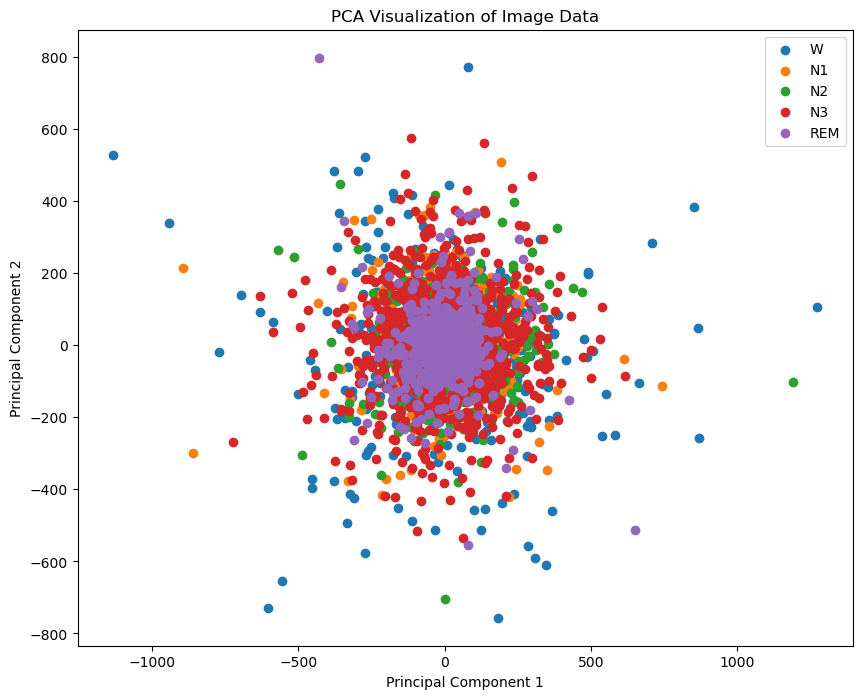

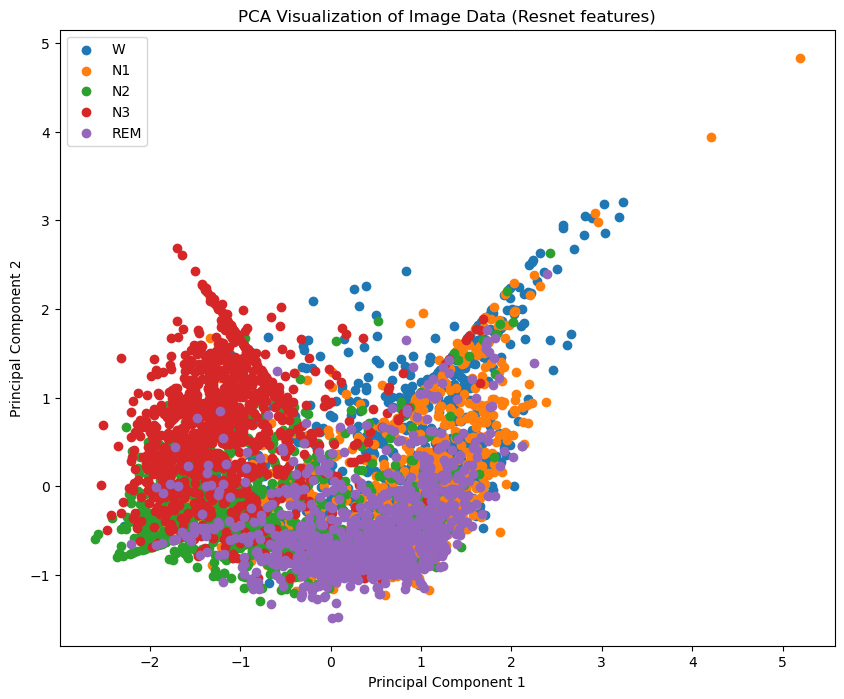

Explained variance ratio: [0.48955593 0.24768264]
Cumulative explained variance: [0.48955593 0.73723857]


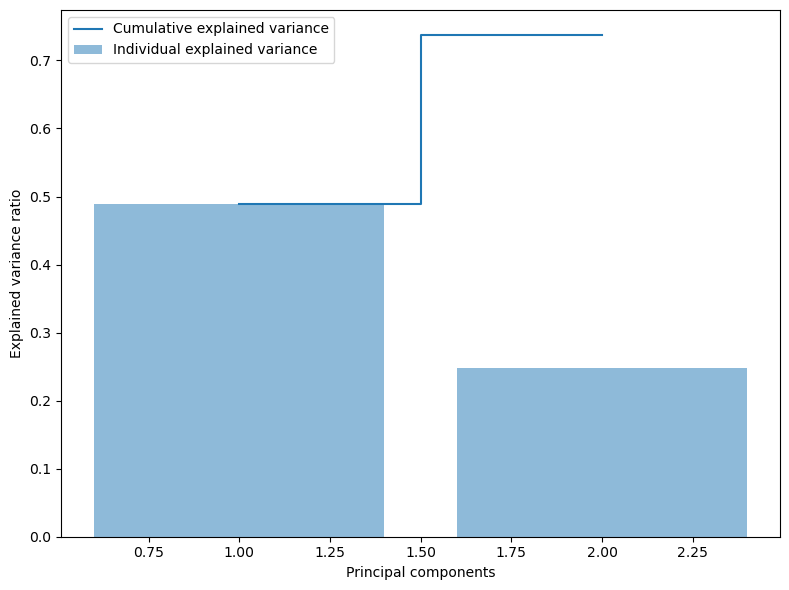

In [32]:
# Assuming your dataset has a 'classes' attribute containing class names
# class_names = dataset.clases

# Assuming you have a DataLoader named 'train_loader'
for batch in train_balanced_dataloader:
    images, labeli = batch
    images = images.view(-1, 1, images.shape[-1])
    
    visualize_pca2(images, labeli, flipped_afib_dict, attn_model)

In [33]:
# Function to apply t-SNE and visualize the results
def visualize_tsne(images, labels, class_names, model):
    # Flatten the images to vectors (assuming they are 2D images)
    # Flatten the images to vectors (assuming they are 2D images)
    flattened_images = images.view(images.size(0), -1).numpy()

    # Standardize the data before applying t-SNE
    scaler = StandardScaler()
    standardized_images = scaler.fit_transform(flattened_images)

    # Apply t-SNE
    tsne = TSNE(n_components=2, random_state=42)
    reduced_features = tsne.fit_transform(standardized_images)

    # Plot the results
    plt.figure(figsize=(10, 8))
    for i in range(5):
        indices = labels == i
        plt.scatter(reduced_features[indices, 0], reduced_features[indices, 1], label=class_names[i])

    plt.title('t-SNE Visualization of Image Data')
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.legend()
    plt.show()

    # Evaluate the model and get features
    model.eval()
    with torch.no_grad():
        model_features = model(images)

    # Standardize model features before applying t-SNE
    standardized_model_features = scaler.fit_transform(model_features.view(-1, model_features.size(-1)).cpu().numpy())

    # Apply t-SNE to model features
    reduced_features_model = tsne.fit_transform(standardized_model_features)

    # Plot the results
    plt.figure(figsize=(10, 8))
    for i in range(5):
        indices = labels == i
        plt.scatter(reduced_features_model[indices, 0], reduced_features_model[indices, 1], label=class_names[i])

    plt.title('t-SNE Visualization of Image Data (ResNet features)')
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.legend()
    plt.show()

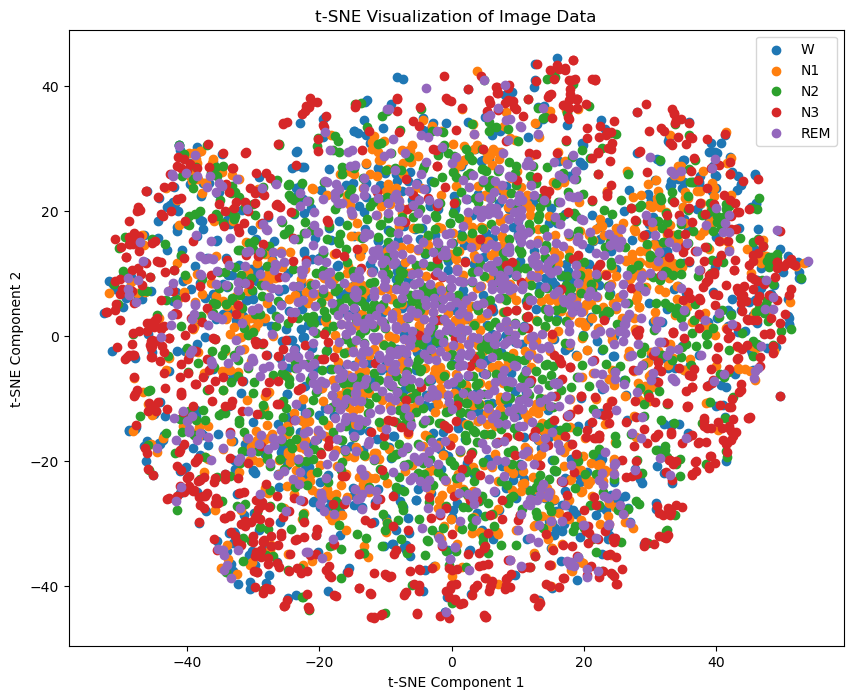

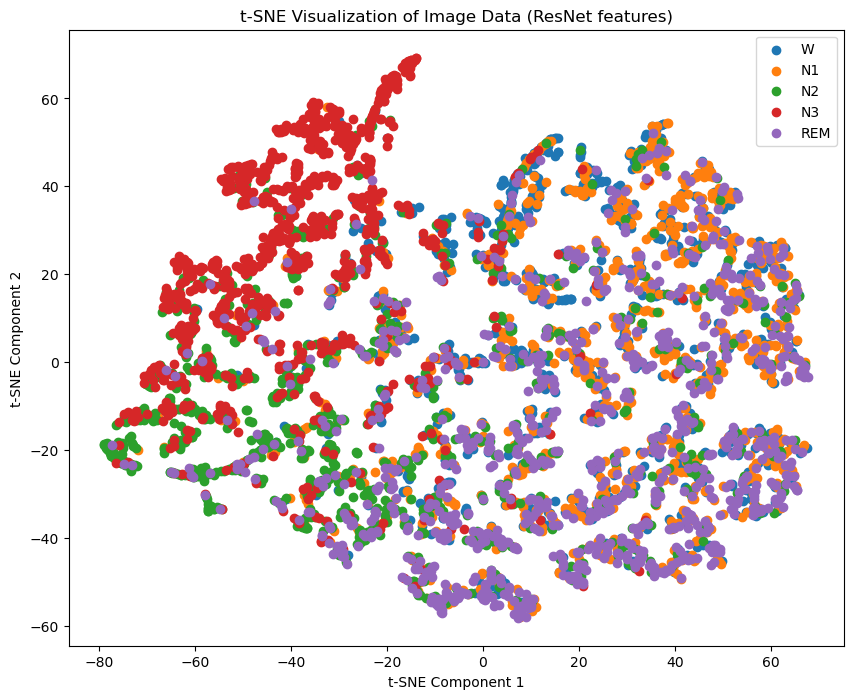

In [34]:
# Assuming your dataset has a 'classes' attribute containing class names
# class_names = dataset.clases

# Assuming you have a DataLoader named 'train_loader'
for batch in train_balanced_dataloader:
    images, labeli = batch
    images = images.view(-1, 1, images.shape[-1])
    
    visualize_tsne(images, labeli, flipped_afib_dict, attn_model)

### 1. Dynamic Margin-CL

In [35]:
class HATCL_LOSS(torch.nn.Module):
    def __init__(self, temperature=0.5):
        super(HATCL_LOSS, self).__init__()
        self.temperature = temperature

    def forward(self, features):
        # Normalize the feature vectors
        features_normalized = F.normalize(features, dim=-1, p=2)

        # Calculate the cosine similarity matrix
        similarities = torch.matmul(features_normalized, features_normalized.T)
        
        exp_similarities = torch.exp(similarities / self.temperature)
        
        # Removing the similarity of a window with itself i.e main diagonal
        exp_similarities = exp_similarities - torch.diag(exp_similarities.diag())        

        # Lower diagonal elements represent positive pairs
        positives = torch.diagonal(exp_similarities, offset=-1)

        # The denominator is the sum of the column vectors minus the positives
        denominator = torch.sum(exp_similarities[:,:-1], dim=0) - positives
        
        # Calculate NT-Xent loss
        loss = -torch.log(positives / denominator).mean()

        return loss

In [36]:
class LS_HATCL_LOSS(torch.nn.Module):
    def __init__(self, temperature=0.5):
        super(LS_HATCL_LOSS, self).__init__()
        self.temperature = temperature

    def forward(self, features):
        
        # Normalize the feature vectors
        features_normalized = torch.nn.functional.normalize(features, p=2, dim=-1)

        # Calculate the cosine similarity matrix
        similarities = torch.matmul(features_normalized, features_normalized.T)

        
        exp_similarities = torch.exp(similarities / self.temperature)
        
        # Removing the similarity of a window with itself i.e main diagonal
        exp_similarities = exp_similarities - torch.diag(exp_similarities.diag())        

        # Lower diagonal elements represent positive pairs
        lower_diag = torch.diagonal(exp_similarities, offset=-1)
        
        # The numerator is the sum of shifted left and right of the positive pairs
        numerator = lower_diag[1:] + lower_diag[:-1]
        
        # The denominator is the sum of the column vectors minus the positives
        denominator = torch.sum(exp_similarities[:,:-2], dim=0) - lower_diag[:-1]\
                + (torch.sum(exp_similarities[:,1:-1], dim=0)  - (lower_diag[1:] + lower_diag[:-1]))
        
        
        # Calculate NT-Xent loss
        loss = -torch.log(numerator / denominator).mean()
        
#         print("Similarities: ", similarities)
#         print("Exp Similarities: ", exp_similarities)
#         print("Numerator: ", numerator)
#         print("Denominator: ", denominator)
        
        return loss

In [37]:
def initialize_model(seed):
    set_seed(seed)
    model = FeatureProjector(input_size=178, output_size=32)
    return model

In [38]:
# Instantiate the model
seed = 42
attn_model = initialize_model(seed)

In [39]:
# Define loss function and optimizer
cl_loss = LS_HATCL_LOSS(temperature=1)
optimizer = optim.AdamW(attn_model.parameters(), lr=0.01)  # Example optimizer

# Move model to device
device = torch.device("cpu" if torch.backends.mps.is_available() and torch.backends.mps.is_built() else "cpu")
attn_model.to(device)
# l = 0.4

# Training and validation loop
num_epochs = 15

for epoch in range(num_epochs):
    # Training phase
    attn_model.train()  # Set the model to training mode
    train_running_loss = 0.0

    for batch_idx, (time_series, labels) in enumerate(tqdm(train_loader)):
        time_series = time_series.to(device)
        
        
        
        # Forward pass
        features = attn_model(time_series)
        
        # Flatten features to have dimensions [batch_size * sequence_length, feature dim]
        features = features.reshape(-1, features.size(-1))

        # Compute training loss
        contrast_loss = cl_loss(features)
        
        train_loss = contrast_loss


        # Backward pass and optimization
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()



        # Update training statistics
        train_running_loss += train_loss.item() * time_series.size(0)

#         # Log training loss to Wandb
#         if config.WANDB and batch_idx % 10 == 0:
#             wandb.log({'Train Loss': train_running_loss /(batch_idx + 1), 'Epoch': epoch})


    train_epoch_loss = train_running_loss / len(train_loader.dataset)
    print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_epoch_loss:.4f}")

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:21<00:00,  1.41it/s]


Epoch 1/15, Train Loss: 8.6914


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:21<00:00,  1.40it/s]


Epoch 2/15, Train Loss: 8.6554


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:21<00:00,  1.39it/s]


Epoch 3/15, Train Loss: 8.6388


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:21<00:00,  1.41it/s]


Epoch 4/15, Train Loss: 8.6305


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:21<00:00,  1.37it/s]


Epoch 5/15, Train Loss: 8.6272


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:21<00:00,  1.42it/s]


Epoch 6/15, Train Loss: 8.6247


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:24<00:00,  1.23it/s]


Epoch 7/15, Train Loss: 8.6203


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:26<00:00,  1.14it/s]


Epoch 8/15, Train Loss: 8.6172


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:21<00:00,  1.42it/s]


Epoch 9/15, Train Loss: 8.6152


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:21<00:00,  1.38it/s]


Epoch 10/15, Train Loss: 8.6120


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:21<00:00,  1.37it/s]


Epoch 11/15, Train Loss: 8.6096


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:21<00:00,  1.39it/s]


Epoch 12/15, Train Loss: 8.6071


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:22<00:00,  1.35it/s]


Epoch 13/15, Train Loss: 8.6092


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:21<00:00,  1.38it/s]


Epoch 14/15, Train Loss: 8.6073


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:21<00:00,  1.42it/s]

Epoch 15/15, Train Loss: 8.6054


In [40]:
# Calculate Davies-Bouldin Index
db_index = davies_bouldin_score(images.squeeze(), labeli)
ch_index = calinski_harabasz_score(images.squeeze(), labeli)
slh_index = silhouette_score(images.squeeze(), labeli)

print(f"Davies-Bouldin Index: {db_index}")
print(f"Calinski Harabasz Index: {ch_index}")
print(f"Silhouette Index: {slh_index}")

Davies-Bouldin Index: 44.54605214670387
Calinski Harabasz Index: 1.3113986743613268
Silhouette Index: -0.11990344524383545


In [41]:
attn_model.eval()
with torch.no_grad():
    features = attn_model(images)

In [42]:
kmeans = KMeans(n_clusters=5, random_state=1).fit(features.detach().squeeze())
cluster_labels = kmeans.labels_

# Calculate Davies-Bouldin Index
db_index2 = davies_bouldin_score(features.detach().squeeze(), cluster_labels)
ch_index2 = calinski_harabasz_score(features.detach().squeeze(), cluster_labels)
slh_index2 = silhouette_score(features.detach().squeeze(), cluster_labels)

print(f"Davies-Bouldin Index Features: {db_index2}")
print(f"Calinski Harabasz Index Features: {ch_index2}")
print(f"Silhouette Index Features: {slh_index2}")

Davies-Bouldin Index Features: 6.315995923556608
Calinski Harabasz Index Features: 224.3350830386761
Silhouette Index Features: -0.07489730417728424


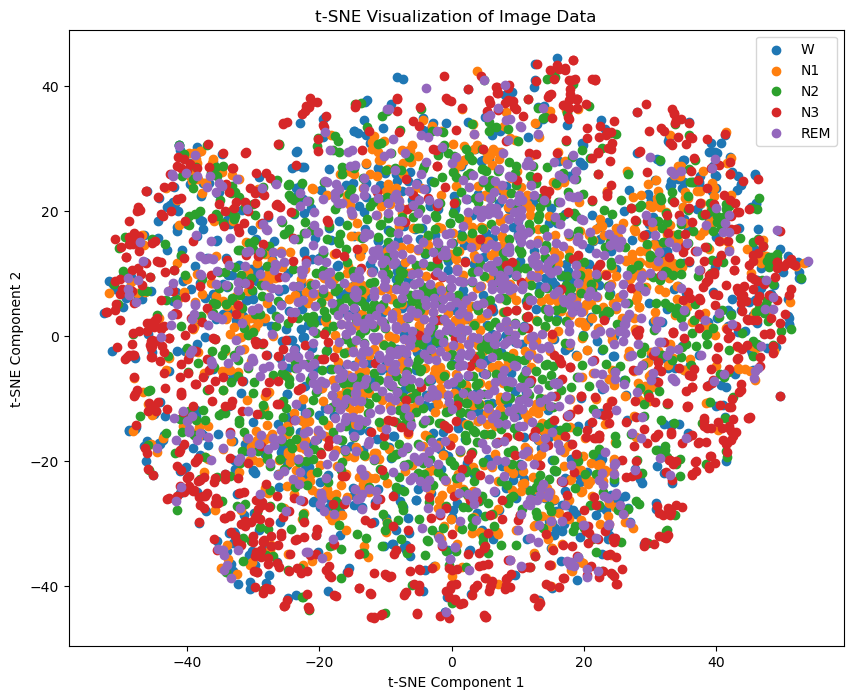

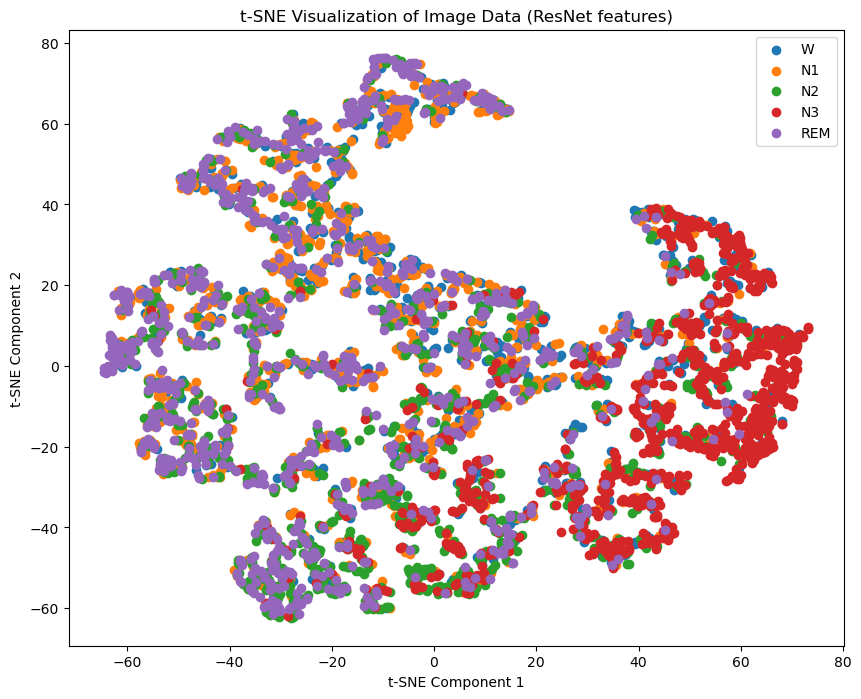

In [43]:
visualize_tsne(images, labeli, flipped_afib_dict, attn_model)

## Linear Evaluation - Frozen Backbone

In [117]:
# Example: Define a frozen backbone and a linear classifier
class LinearEvaluation(nn.Module):
    def __init__(self, backbone, num_classes):
        super(LinearEvaluation, self).__init__()
        self.backbone = backbone
        self.backbone.requires_grad_(False)
        self.bn1 = nn.BatchNorm1d(num_features=1)
        self.classifier = nn.Linear(32, num_classes)  # Add linear classifier
    
    def forward(self, x):
        with torch.no_grad():  # Ensure backbone is not updated
            features = self.backbone(x)  # Extract features using frozen backbone
#             features = self.bn1(features)
        return self.classifier(features)  # Feed features to linear classifier

In [307]:
def linear_evaluation(train_loader, valid_loader, algorithms, seeds, num_epochs):
    diction_algs = {}
        
    
    for alg in algorithms:
        seed_acc = []
        seed_f1 = []
        seed_prec = []
        seed_recall = []
        
        for seed in seeds:
            set_seed(seed)
            frozen_backbone = FeatureProjector(input_size=178, output_size=32)
            frozen_backbone.load_state_dict(torch.load(f'models/my_models/sleepeeg{seed}_{alg}_model_epoch_500.pth',
                                            map_location=torch.device('cpu')))
            
            
            num_activities = 5
            mine_model = LinearEvaluation(frozen_backbone, num_classes=num_activities)
            # Define loss function and optimizer
            criterion = nn.CrossEntropyLoss()
            optimizer = optim.Adam(mine_model.parameters(), lr=0.001)  # Example optimizer

            # Move model to device
            device = torch.device("cpu" if torch.backends.mps.is_available() and torch.backends.mps.is_built() else "cpu")
            mine_model.to(device)

            # Training and validation loop
            num_epochs = num_epochs
            for epoch in tqdm(range(num_epochs)):
                # Training phase
                mine_model.train()  # Set the model to training mode
                train_running_loss = 0.0
                train_correct_predictions = 0
                train_total_samples = 0

                all_preds = []
                all_labels = []

                for time_series, labels in (train_loader):
                    time_series = time_series.to(device)
                    labels = labels.to(device)

                    # Forward pass
                    features = mine_model(time_series)
                    # Flatten y_hat to have dimensions [batch_size * sequence_length, num_classes]
                    y_hat_flat = features.reshape(-1, features.size(-1))

                    # Reshape y to have dimensions [batch_size * sequence_length]
                    labels_flat = labels.view(-1)

                    # Compute training loss
                    train_loss = criterion(y_hat_flat, labels_flat)

                    # Backward pass and optimization
                    optimizer.zero_grad()
                    train_loss.backward()
                    optimizer.step()

                    # Update training statistics
                    train_running_loss += train_loss.item() * time_series.size(0)

                    _, predicted = torch.max(y_hat_flat, 1)
                    train_correct_predictions += (predicted == labels_flat).sum().item()

                    #Store the labels for future computation of F1-score
                    all_preds.extend(predicted.cpu().numpy())
                    all_labels.extend(labels_flat.cpu().numpy())

                    train_total_samples += labels_flat.size(0)

                # Calculate average training loss and accuracy for the epoch
                train_epoch_loss = train_running_loss / len(train_loader.dataset)
                train_epoch_accuracy = 100*train_correct_predictions / train_total_samples

                f1 = f1_score(all_labels, all_preds,average='weighted')

#                 print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_epoch_loss:.4f},\
#                       Train Accuracy: {train_epoch_accuracy:.2f}%, F1-score: {f1:.4f}")
                
            # Validation phase
            mine_model.eval()  # Set the model to evaluation mode
            val_running_loss = 0.0
            val_correct_predictions = 0
            val_total_samples = 0

            with torch.no_grad():
                val_preds = []
                val_labels = []
                for time_series, labels in (valid_loader):
                    time_series = time_series.to(device)
                    labels = labels.to(device)

                    # Forward pass
                    features = mine_model(time_series)

                    # Flatten y_hat to have dimensions [batch_size * sequence_length, num_classes]
                    y_hat_flat = features.reshape(-1, features.size(-1))

                    # Reshape y to have dimensions [batch_size * sequence_length]
                    labels_flat = labels.view(-1)

                    # Compute validation loss
                    val_loss = criterion(y_hat_flat, labels_flat)

                    # Update validation statistics
                    val_running_loss += val_loss.item() * time_series.size(0)

                    _, predicted = torch.max(y_hat_flat, 1)
                    val_correct_predictions += (predicted == labels_flat).sum().item()
                    val_total_samples += labels_flat.size(0)

                    val_preds.extend(predicted.cpu().numpy())
                    val_labels.extend(labels_flat.cpu().numpy())

            # Calculate average validation loss and accuracy for the epoch
            val_epoch_loss = val_running_loss / len(valid_loader.dataset)
            val_epoch_accuracy = 100*val_correct_predictions / val_total_samples

            # Precision and recall using sklearn
            precision = precision_score(val_labels, val_preds, average='macro')
            recall = recall_score(val_labels, val_preds, average='macro')

            f1 = f1_score(val_labels, val_preds, average='weighted')
#             print(f"Epoch {epoch + 1}/{num_epochs}, Val Loss: {val_epoch_loss:.4f},\
#                   Val Accuracy: {val_epoch_accuracy:.2f}%, F1-score: {f1:.2f},\
#                   Precision: {precision:.2f}, Recall: {recall:.2f}")
            
            
            seed_acc.append((round(val_epoch_accuracy,2)))
            seed_f1.append((round(f1,2)))
            seed_prec.append((round(precision,2)))
            seed_recall.append((round(recall,2)))
            
            
        diction_algs[f'{alg}'] = [(round(np.mean(seed_acc),2), round(np.std(seed_acc),2)),
                                   (round(np.mean(seed_f1),2), round(np.std(seed_f1),2)),
                                   (round(np.mean(seed_prec),2), round(np.std(seed_prec),2)),
                                   (round(np.mean(seed_recall),2), round(np.std(seed_recall),2))]
        
    return diction_algs

In [308]:
# algorithms = ['vanilla', 'doubleCL', 'marginCL', 'tnc', 'cpc', 'ts2vec', 'infoTS']
algorithms = ['cost']
seeds = [42, 53, 64, 75]
num_epoch = 50

In [309]:
metric_data = linear_evaluation(train_loader, valid_loader, algorithms, seeds, num_epoch)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [04:42<00:00,  5.65s/it]
/Users/shamba/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [04:50<00:00,  5.81s/it]
/Users/shamba/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

In [121]:
metric_data

{'cost': [(49.54, 0.09), (0.39, 0.0), (0.32, 0.0), (0.25, 0.0)]}

In [122]:
# Function to apply t-SNE and visualize the results
def visualize_tsne123(images, colors, labels, class_names, model):

    # Evaluate the model and get features
    model.eval()
    with torch.no_grad():
        model_features = model(images)

    # Standardize the data before applying t-SNE
    scaler = StandardScaler()
    tsne = TSNE(n_components=2, init='random', learning_rate='auto')

    # Standardize model features before applying t-SNE
    standardized_model_features = scaler.fit_transform(model_features.view(-1, model_features.size(-1)).cpu().numpy())

    # Apply t-SNE to model features
    reduced_features_model = tsne.fit_transform(standardized_model_features)

    # Plot the results
    plt.figure(figsize=(6, 6))
    for i, val in enumerate([0, 3, 4]):
        indices = labels == val
        plt.scatter(reduced_features_model[indices, 0], reduced_features_model[indices, 1], color =colors[i], label=class_names[val])

#     plt.title('t-SNE Visualization of Vanilla CL Features')
#     plt.xlabel('t-SNE Component 1')
#     plt.ylabel('t-SNE Component 2')
    plt.legend(prop={'size': 14, 'family': 'Tahoma'})

    return plt

In [123]:
model = FeatureProjector(input_size=178, output_size=32)

In [124]:
algorithms = ['vanilla', 'tnc', 'cpc', 'cost', 'ts2vec', 'infoTS', 'triplet', 'doubleCL', 'marginCL', 'recons', 'monoselfPAB']

In [125]:
model.load_state_dict(torch.load(f'models/my_models/sleepeeg42_cost_model_epoch_500.pth',
                                            map_location=torch.device('cpu')))

<All keys matched successfully>

In [126]:
# Assuming your dataset has a 'classes' attribute containing class names
# class_names = dataset.clases

# Assuming you have a DataLoader named 'train_loader'
for batch in train_balanced_dataloader:
    images, labeli = batch
    images = images.view(-1, 1, images.shape[-1])

In [127]:
flipped_afib_dict = {0: "wake", 1: "N1", 2: "N2", 3: "non-REM", 4: "REM"}

<function matplotlib.pyplot.show(close=None, block=None)>

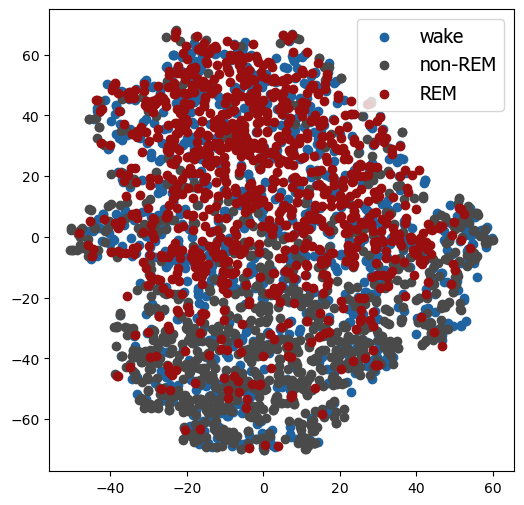

In [128]:
# Define your class names and corresponding colors
class_names = ['Class 0', 'Class 1', 'Class 2']
colors = ['#1F64A1', '#4A4A4A','#990F0F']  # Red, Green, Blue

# Assume `images`, `labels`, and `model` are already defined
plott = visualize_tsne123(images, colors, labeli, flipped_afib_dict, model)
plott.show